# Feature Engineering Homework 
***
**Name**: Pranav Kumar Sivakumar 

**Kaggle Username**: $PranavPKS$
***

This assignment is due on Moodle by **5pm on Friday February 23rd**. Additionally, you must make at least one submission to the **Kaggle** competition before it closes at **4:59pm on Friday February 23rd**. Submit only this Jupyter notebook to Moodle. Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***

When people are discussing popular media, there’s a concept of spoilers. That is, critical information about the plot of a TV show, book, or movie that “ruins” the experience for people who haven’t read / seen it yet.

The goal of this assignment is to do text classification on forum posts from the website [tvtropes.org](http://tvtropes.org/), to predict whether a post is a spoiler or not. We'll be using the logistic regression classifier provided by sklearn.

Unlike previous assignments, the code provided with this assignment has all of the functionality required. Your job is to make the functionality better by improving the features the code uses for text classification.

**NOTE**: Because the goal of this assignment is feature engineering, not classification algorithms, you may not change the underlying algorithm or it's parameters

This assignment is structured in a way that approximates how classification works in the real world: Features are typically underspecified (or not specified at all). You, the data digger, have to articulate the features you need. You then compete against others to provide useful predictions.

It may seem straightforward, but do not start this at the last minute. There are often many things that go wrong in testing out features, and you'll want to make sure your features work well once you've found them.


## Kaggle In-Class Competition 
***

In addition to turning in this notebook on Moodle, you'll also need to submit your predictions on Kaggle, an online tournament site for machine learning competitions. The competition page can be found here:  

[https://www.kaggle.com/c/feature-engineering-csci-5622-spring-2018](https://www.kaggle.com/c/feature-engineering-csci-5622-spring-2018)

Additionally, a private invite link for the competition has been posted to Piazza. 

The starter code below has a `model_predict` method which produces a two column CSV file that is correctly formatted for Kaggle (predictions.csv). It should have the example Id as the first column and the prediction (`True` or `False`) as the second column. If you change this format your submissions will be scored as zero accuracy on Kaggle. 

**Note**: You may only submit **THREE** predictions to Kaggle per day.  Instead of using the public leaderboard as your sole evaluation processes, it is highly recommended that you perform local evaluation using a validation set or cross-validation. 

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import re
import string
from scipy.sparse import coo_matrix, hstack
#from sklearn.model_selection import GridSearchCV
from scipy import sparse
wl = WordNetLemmatizer()
import pickle
#from sklearn.feature_selection import SelectFromModel
from nltk.tokenize import word_tokenize

In [ ]:
import json
import http.client
import time
import re

#This data extraction takes atleast 10 mins
def get_gr(txt):
    conn = http.client.HTTPSConnection("api.themoviedb.org")
    conn.request("GET", "/3/search/tv?page=1&query="+txt+"&language=en-US&api_key=ffdfecf0830968b442b85db5a9cb58a9")
    data = conn.getresponse().read()
    if json.loads(data)['results']:
        id_temp = json.loads(data)['results'][0]['id']
        try:
            conn.request("GET", "/3/tv/"+str(id_temp)+"?language=en-US&api_key=ffdfecf0830968b442b85db5a9cb58a9")
        except:
            conn.request("GET", "/3/tv/"+str(id_temp)+"?language=en-US&api_key=ffdfecf0830968b442b85db5a9cb58a9")
        dd = conn.getresponse().read()
        temp_genre=""
        if json.loads(dd)['genres']:
            for j in range(len(json.loads(dd)['genres'])):
                temp_genre = temp_genre + json.loads(dd)['genres'][j]['name'].replace("& ", "") + " "
            g = temp_genre[:-1]
        else:
            g = ""
        if json.loads(dd)['episode_run_time']:
            r= float(json.loads(dd)['episode_run_time'][0])/100.0
        else:
            r= 0.4
        if json.loads(dd)['number_of_episodes']:
            ep= float(json.loads(dd)['number_of_episodes'])/100.0
        else:
            ep= 1.3
        return g,r,ep
    else:
        return "",0.4,1.3
    
def data_col(filepath):
    genres={}
    runtime={}
    df = pd.read_csv(filepath)
    pages = list(set(df["page"]))
    for i in range(len(pages)):
        txt = ' '.join(re.findall(r'[A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))', pages[i])).lower().replace(" ","%20")
        try:
            genres[pages[i]],runtime[pages[i]],episodes[pages[i]]=get_gr(txt)
        except:
            #print(i)
            time.sleep(3) 
            genres[pages[i]],runtime[pages[i]],episodes[pages[i]]=get_gr(txt)

    gen=[]
    rt=[]
    ep=[]
    for i in range(len(df["page"])):
        gen.append(genres[df["page"][i]])
        rt.append(runtime[df["page"][i]])
        ep.append(episodes[df["page"][i]])
    return gen,rt,ep
        
gen,rt,ep = data_col("../data/spoilers/train.csv")
gen_test,rt_test,ep_test = data_col("../data/spoilers/test.csv")

with open("apiall.txt", "wb") as fp:
    pickle.dump([gen,gen_test,rt,rt_test,ep,ep_test], fp)

In [2]:
with open("apiall.txt", "rb") as fp:
    gen,gen_test,rt,rt_test,ep,ep_test = pickle.load(fp)

In [ ]:
from nltk.tag import StanfordNERTagger,StanfordPOSTagger

#This data extraction takes atleast 9 hours and requires the files(.jar files, .tagger file and .gz file) denoted below
def nertspos(filepath):
    model = 'stanford-ner-2017-06-09/classifiers/english.all.3class.distsim.crf.ser.gz'
    jar = 'stanford-ner-2017-06-09/stanford-ner.jar'
    ner_tagger = StanfordNERTagger(model, jar, encoding='utf8')

    jar2 = 'stanford-postagger-2017-06-09/stanford-postagger.jar'
    model2 = 'stanford-postagger-2017-06-09/models/english-bidirectional-distsim.tagger'
    pos_tagger = StanfordPOSTagger(model2, jar2, encoding='utf8')

    df = pd.read_csv(filepath)
    pos=[]
    nerts=[]
    for i in range(len(df['sentence'])):
        nerts.append(' '.join([ y for (x,y) in ner_tagger.tag(word_tokenize(df['sentence'][i])) if y!='O']))
        pos.append(' '.join([ y for (x,y) in pos_tagger.tag(word_tokenize(df['sentence'][i])) if y in ['VB','VBD','VBG','VBN','VBP','VBZ']]))

    return nerts,pos


nerts,pos = nertspos("../data/spoilers/train.csv")
nerts_test,pos_test = nertspos("../data/spoilers/test.csv")

with open("allparse.txt", "wb") as fp:
    pickle.dump([nerts,nerts_test,pos,pos_test],fp)

In [3]:
with open("allparse.txt", "rb") as fp:
    nerts,nerts_test,pos,pos_test = pickle.load(fp)

### [25 points] Problem 1: Feature Engineering 
***

The `FeatEngr` class is where the magic happens.  In it's current form it will read in the training data and vectorize it using simple Bag-of-Words.  It then trains a model and makes predictions.  

25 points of your grade will be generated from your performance on the the classification competition on Kaggle. The performance will be evaluated on accuracy on the held-out test set. Half of the test set is used to evaluate accuracy on the public leaderboard.  The other half of the test set is used to evaluate accuracy on the private leaderboard (which you will not be able to see until the close of the competition). 

You should be able to significantly improve on the baseline system (i.e. the predictions made by the starter code we've provided) as reported by the Kaggle system.  Additionally, the top **THREE** students from the **PRIVATE** leaderboard at the end of the contest will receive 5 extra credit points towards their Problem 1 score.


In [4]:
def preprocess(example):
    if len(re.findall(r'\!', example)) > 0:
        example = example + " PUNCxEXCLAMATIONPOINT"
    if len(re.findall(r'\?', example)) > 0:
        example = example + " PUNCxQUESTIONMARK"
    if len(re.findall(r'[\?\!]{2,}', example)) > 0:
        example = example + " PUNCxINTERROBANG"
    return (' '.join([ wl.lemmatize(word,'v') for word in list(filter(None,re.sub(r'[^\w\s]','',example).lower().split(' ')))]))

def caplen(examples):
    ll=[]
    for sentence in examples:
        ll.append(float(sum(1 for c in sentence if c.isupper())))
    return ll

class FeatEngr:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(ngram_range=(1, 3), analyzer='word', lowercase=False,stop_words='english',strip_accents='ascii')
        self.tf_transformer = TfidfVectorizer(ngram_range=(1, 3), analyzer='word', preprocessor= preprocess, stop_words='english', norm = 'l2', use_idf=True, smooth_idf= True, strip_accents='ascii')
        self.tf_transformer2 = TfidfVectorizer(analyzer='word',use_idf=True,smooth_idf=True)
        self.tf_transformer3 = TfidfVectorizer(ngram_range=(1, 3), analyzer='word', stop_words='english', norm = 'l2', use_idf=True, smooth_idf= True, strip_accents='ascii')
        self.tf_transformer4 = TfidfVectorizer(analyzer='word',use_idf=True,smooth_idf=True)
        self.tf_transformer5 = TfidfVectorizer(analyzer='word',use_idf=True,smooth_idf=True)
        self.tf_transformer6 = TfidfVectorizer(analyzer='word',use_idf=True,smooth_idf=True)
                
    def build_train_features(self, examples,tropes,genres,nerts,pos,rts,eps):
        """
        Method to take in training text features and do further feature engineering 
        Most of the work in this homework will go here, or in similar functions  
        :param examples: currently just a list of forum posts  
        """
        
        allfe = FeatureUnion([("counts", self.vectorizer), ("tfidf", self.tf_transformer),("tfidf2", self.tf_transformer3)]).fit_transform(examples)
        tp = self.tf_transformer2.fit_transform(tropes)
        tp2 = self.tf_transformer4.fit_transform(genres)
        tp3 = self.tf_transformer5.fit_transform(nerts)
        tp4 = self.tf_transformer6.fit_transform(pos)
        ll = np.array(caplen(examples))
        return sparse.csr_matrix(hstack((coo_matrix(allfe),coo_matrix(tp),coo_matrix(tp2),coo_matrix(tp3),coo_matrix(tp4),np.array(rts)[:,None],ll[:,None],np.array(eps)[:,None])))

    def get_test_features(self, examples,tropes,genres,nerts,pos,rts,eps):
        """
        Method to take in test text features and transform the same way as train features 
        :param examples: currently just a list of forum posts  
        """        
        
        allfe = FeatureUnion([("counts", self.vectorizer), ("tfidf", self.tf_transformer),("tfidf2", self.tf_transformer3)]).transform(examples)
        tp = self.tf_transformer2.transform(tropes)
        tp2 = self.tf_transformer4.transform(genres)
        tp3 = self.tf_transformer5.transform(nerts)
        tp4 = self.tf_transformer6.transform(pos)
        ll = np.array(caplen(examples))
        return sparse.csr_matrix(hstack((coo_matrix(allfe),coo_matrix(tp),coo_matrix(tp2),coo_matrix(tp3),coo_matrix(tp4),np.array(rts)[:,None],ll[:,None],np.array(eps)[:,None])))
        

    def show_top10(self):
        """
        prints the top 10 features for the positive class and the 
        top 10 features for the negative class. 
        """
        a1 = np.asarray(self.vectorizer.get_feature_names())
        a2 = np.asarray(self.tf_transformer.get_feature_names())
        a3 = np.asarray(self.tf_transformer2.get_feature_names())
        a4 = np.asarray(self.tf_transformer3.get_feature_names())
        a5 = np.asarray(self.tf_transformer4.get_feature_names())
        a6 = np.asarray(self.tf_transformer5.get_feature_names())
        a7 = np.asarray(self.tf_transformer6.get_feature_names())
        a8 = np.asarray(['runtime','caplen','num_episodes'])
        #a9 = np.asarray(self.tf_transformer8.get_feature_names())
        feature_names = np.hstack(( a1,a2,a3,a4,a5,a6,a7,a8)).ravel()
        top10 = np.argsort(self.logreg.coef_[0])[-10:]
        bottom10 = np.argsort(self.logreg.coef_[0])[:10]
        print("Pos: %s" % " - ".join(feature_names[top10]))
        print("Neg: %s" % " - ".join(feature_names[bottom10]))
                
    def train_model(self, random_state=1234):
        """
        Method to read in training data from file, and 
        train Logistic Regression classifier. 
        
        :param random_state: seed for random number generator 
        """
        
        from sklearn.linear_model import LogisticRegression 
        
        # load data 
        dfTrain = pd.read_csv("../data/spoilers/train.csv")
        
        # get training features and labels 
         
        self.X_train = self.build_train_features(list(dfTrain["sentence"]),list(dfTrain["trope"]),list(gen),list(nerts),list(pos),list(rt),list(ep))
        #self.X_train = self.build_train_features(list(dfTrain["sentence"][:-500]),list(dfTrain["trope"][:-500]),list(gen[:-500]),list(nerts[:-500]),list(pos[:-500]),list(rt[:-500]))
        
        
        self.y_train = np.array(dfTrain["spoiler"], dtype=int)
        #self.y_train = np.array(dfTrain["spoiler"][:-500], dtype=int)
        
        #self.X_val = self.get_test_features(list(dfTrain["sentence"][-500:]),list(dfTrain["trope"][-500:]),list(gen[-500:]),list(nerts[-500:]),list(pos[-500:]),list(rt[-500:]))
        #self.y_val = np.array(dfTrain["spoiler"][-500:], dtype=int)
        
        # train logistic regression model.  !!You MAY NOT CHANGE THIS!! 
        self.logreg =  LogisticRegression(C=1.0,random_state=random_state,penalty='l2')
        self.logreg.fit(self.X_train, self.y_train)
        
        
    def model_predict(self):
        """
        Method to read in test data from file, make predictions
        using trained model, and dump results to file 
        """
        
        # read in test data 
        dfTest  = pd.read_csv("../data/spoilers/test.csv")
        
        # featurize test data 
        self.X_test = self.get_test_features(list(dfTest["sentence"]),list(dfTest["trope"]),list(gen_test),list(nerts_test),list(pos_test),list(rt_test),list(ep_test))
        
        #val_pred = self.logreg.predict(self.X_val)
        # make predictions on test data 
        pred = self.logreg.predict(self.X_test)

        # dump predictions to file for submission to Kaggle  
        pd.DataFrame({"spoiler": np.array(pred, dtype=bool)}).to_csv("prediction.csv", index=True, index_label="Id")
        #return val_pred

In [5]:
# Instantiate the FeatEngr clas 
feat = FeatEngr()

# Train your Logistic Regression classifier 
feat.train_model(random_state=1230)

# Shows the top 10 features for each class 
feat.show_top10()

# Make prediction on test data and produce Kaggle submission file 
#val_pred = feat.model_predict()
feat.model_predict()

Pos: working hauser like - kill - worse hints - zod blue - zombies massacred group - reveal - worf hadn - end - zod - die
Neg: women - witnessed visiting - world weary - young donald trump - work heavy bias - yellow caution - willingness use - reality - talk - working magic radar


In [33]:
np.sum(np.equal(val_pred,feat.y_val))/len(feat.y_val) #Accuracy on the validation set

0.72399999999999998

In [6]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=None)
acc=[]
for train_index, test_index in kf.split(feat.X_train):
    X_train, X_test = feat.X_train[train_index], feat.X_train[test_index]
    y_train, y_test = feat.y_train[train_index], feat.y_train[test_index]
    feat.logreg.fit(X_train, y_train)
    pred = feat.logreg.predict(X_test)
    acc.append(np.sum(np.equal(pred,y_test))/len(y_test))
print("Accuracy: "+str(np.mean(np.array(acc))*100)+"%")

Accuracy: 74.4611528822%


### [25 points] Problem 2: Motivation and Analysis 
***

The job of the written portion of the homework is to convince the grader that:

- Your new features work
- You understand what the new features are doing
- You had a clear methodology for incorporating the new features

Make sure that you have examples and quantitative evidence that your features are working well. Be sure to explain how you used the data (e.g., did you have a validation set? did you do cross-validation?) and how you inspected the results. In addition, it is very important that you show some kind of an **error analysis** throughout your process.  That is, you should demonstrate that you've looked at misclassified examples and put thought into how you can craft new features to improve your model. 

A sure way of getting a low grade is simply listing what you tried and reporting the Kaggle score for each. You are expected to pay more attention to what is going on with the data and take a data-driven approach to feature engineering.

***
The training has been validated in both the ways,
- Had arbitrarily chosen portions of the training data (like last 500 tuples) as a hold-out/validation set
- Have also done cross validation using k-Fold method with 5 data_splits with shuffling, to lessen the model's variance effect on validation 

The following steps to include features had adequately incremented the cross-validation scores here, but may or maynot reflect the same change in Kaggle, (expecting to reflect the increase in the private leaderboard).

Changed the Count vectorizer to Tf-idf vectorizer, to minimize the impact of the document-specific unnecessary stop-words (inverse document frequency helps here). Also modified the argument to include features based on n-grams with n ranging from 1 to 3, the accuracy decreased if it is taken beyond that (also there is an exponential increase in the number of features).
To n-gram features inclusion is corroborated with the display of some of the top 10 features like (taken from above),
*** working hauser like - zod blue - worse hints - zombies massacred group - worf hadn - witnessed visiting - world weary - work heavy bias - young donald trump - yellow caution - willingness use - working magic radar - years old hell***

Initially did lemmatization to every sentence to group the counts of the words based on their root words, most text based pre-processing has to undergo stemming/lemmatization to avoid noisy data.
Before lemmatization, I removed all the punctuations and made it to lowercase words. 

I had few examples that had one or more symbols like '!','?' which were misclassified,
so added a string for indicating the presence of one/more punctuations, since the punctuations were already removed for lemmatization.
The probability of not being a spoiler was higher if the sentence had one/more symbols.
The counts of True and False of one of the case('!' symbol) is shown below

In [7]:
df = pd.read_csv("../data/spoilers/train.csv")
t=0
f=0
for i in range(len(df['sentence'])):
    if len(re.findall(r'\!', df['sentence'][i])) > 0:
        if df['spoiler'][i] == True:
            t=t+1
        else:
            f=f+1
print(t,f)

142 223


After inspecting the other columns in the provided dataset, the column ***trope*** had common elements among both the training and test sets, but not the ***page*** column. So included a separate vectorizer for the trope column and concatenated the resultant matrix with the previous matrix.

Spoiler detection can be made effective if the capital letters were not reduced to lowercase (that was done during preprocessing). To overcome this drawback, I added two extensions to the feature extraction,
- Added a separate vectorizer that has actual data without preprocessing (also not making it to lowercase by default) and combined to the first vectorizer using ***FeatureUnion***.
- Also added a separate vectorizer that runs with the counts of capital letters in each sentence obtained from the caplen method.
To improve the effect of non-preprocessing, added another vectorizer to the FeatureUnion that takes in data in lowercase without preprocessing.

The above three inclusions increased the cross-validation accuracy by 10 % above the baseline

The following are some of the additional features that were extracted, from the web through APIs (or) using literature based parsers.
#### - Genres, Running times and Number of episodes
The genre of a media, the length of the work and the total number of episodes are some of the useful indicators of whether it is likely to have a spoiler or not. The data was collected using the API provided by the website 'themoviedb'. Genres are made into strings with tags separated by space, for each of the sentence and later sent to a separate vectorizer, which is combined with the whole for the logreg. 

Based on experiments, Genres like Drama, Fantasy, Sci-Fi are most likely to have a spoiler.
Similarly Comedy genre is most likely to not have a spoiler.
These observations are illustrated below with the histograms,

In [8]:
gen_t=[]
gen_f=[]
for i in range(len(df['sentence'])):
    if df['spoiler'][i] == True:
        gen_t = gen_t + gen[i].split(' ')
    if df['spoiler'][i] == False:
        gen_f = gen_f + gen[i].split(' ')

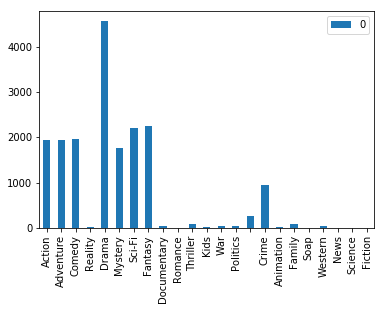

In [9]:
from collections import Counter
%matplotlib inline
gen_counts = Counter(gen_t)
dft = pd.DataFrame.from_dict(gen_counts, orient='index')
dft.plot(kind='bar')

This graph essentially shows the counts of spoilers in the respective genres 

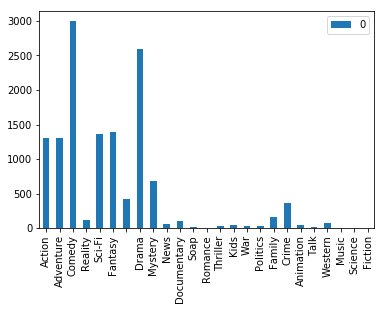

In [10]:
gen_counts = Counter(gen_f)
dff = pd.DataFrame.from_dict(gen_counts, orient='index')
dff.plot(kind='bar')

Similarly this histogram denotes all the counts of non-spoilers in the respective genres.

The univariate distribution of observations along the runtimes are flexibly plotted below, 

In [11]:
rt_t=[]
rt_f=[]
rt_new = [i * 100 for i in rt]
for i in range(len(df['sentence'])):
    if df['spoiler'][i] == True:
        rt_t.append(rt_new[i])
    if df['spoiler'][i] == False:
        rt_f.append(rt_new[i])

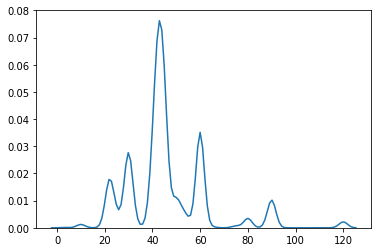

In [12]:
import seaborn as sns
sns.distplot(rt_t,hist=False)#X-axis is the runtime

From this graph, it can be observed that spoilers are more likely to occur if the runtime of the episode of the TV show is near 40 to 45 mins. 

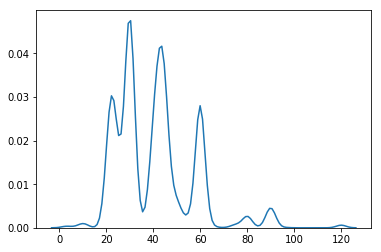

In [13]:
sns.distplot(rt_f,hist=False)#X-axis is the runtime

From this graph, it can be observed that spoilers are less likely to occur if the runtime of the episode of the TV show is near 30 to 35 mins or from 45 to 50 mins. 

The number of episodes of the TV shows also plays a major role in detecting whether it may have a spoiler or not. To support this statement frequency graphs are plotted below.

In [14]:
ep_t=[]
ep_f=[]
ep_new = [int(i * 100) for i in ep]
for i in range(len(df['sentence'])):
    if df['spoiler'][i] == True:
        ep_t.append(ep_new[i])
    if df['spoiler'][i] == False:
        ep_f.append(ep_new[i])

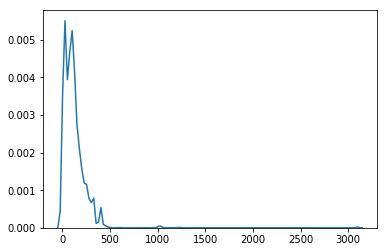

In [15]:
sns.distplot(ep_t,hist=False)#X-axis is the number of episodes

Based on this graph, it can be inferred that shows with hundreds (less than 500) of episodes tend to have more spoilers 

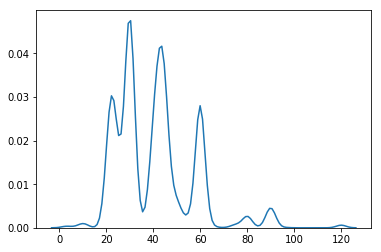

In [16]:
sns.distplot(rt_f,hist=False)#X-axis is the number of episodes

Based on this plot, it can be observed that shows with less number of episodes (less than 70) are less likely to have spoilers

***NER and POS tags***

The other set of features are based on Stanford parsers to extract the presence of Named Entities and Parts of Speech for all the sentences. This extraction generally takes hours to run. From the recognition of Named Entities, 'O' tags are discarded, Similarly only Verb tags are taken from the Parts of Speech tags. The extracted tags are made as strings with all the corresponding tags per sentence and then sent to a vectorizer to take care of the frequencies, which is combined with the whole for the logreg (individual vecorizers for both the extractors).  

In [17]:
nert_t={'LOCATION':0,'ORGANIZATION':0,'PERSON':0}
nert_f={'LOCATION':0,'ORGANIZATION':0,'PERSON':0}
ct={'LOCATION':0,'ORGANIZATION':0,'PERSON':0}
cf={'LOCATION':0,'ORGANIZATION':0,'PERSON':0}
for i in range(len(df['sentence'])):
    if df['spoiler'][i] == True:
        if nerts[i].split(' ')[0] != '':
            tempd = Counter(nerts[i].split(' '))
            for key in tempd:
                nert_t[key] = nert_t[key] + tempd[key]
                ct[key] = ct[key] + 1
    if df['spoiler'][i] == False:
        if nerts[i].split(' ')[0] != '':
            tempd = Counter(nerts[i].split(' '))
            for key in tempd:
                nert_f[key] = nert_f[key] + tempd[key]
                cf[key] = cf[key] + 1

In [18]:
for key in nert_t:
    print("Average number of "+key+" in a spoiler is: "+str(nert_t[key]/ct[key]))
for key in nert_f:
    print("Average number of "+key+" in a non-spoiler is: "+str(nert_f[key]/cf[key]))

Average number of LOCATION in a spoiler is: 1.3370535714285714
Average number of ORGANIZATION in a spoiler is: 1.475195822454308
Average number of PERSON in a spoiler is: 2.037411526794742
Average number of LOCATION in a non-spoiler is: 1.4689119170984455
Average number of ORGANIZATION in a non-spoiler is: 1.7085714285714286
Average number of PERSON in a non-spoiler is: 2.016739203213927


So, for higher number of ORGANIZATION tags makes it more probable to have not have a spoiler

In [19]:
pos_t={'VBZ':0, 'VB':0, 'VBN':0, 'VBP':0, 'VBD':0, 'VBG':0}
pos_f={'VBZ':0, 'VB':0, 'VBN':0, 'VBP':0, 'VBD':0, 'VBG':0}
ct={'VBZ':0, 'VB':0, 'VBN':0, 'VBP':0, 'VBD':0, 'VBG':0}
cf={'VBZ':0, 'VB':0, 'VBN':0, 'VBP':0, 'VBD':0, 'VBG':0}
for i in range(len(df['sentence'])):
    if df['spoiler'][i] == True:
        if pos[i].split(' ')[0] != '':
            tempd = Counter(pos[i].split(' '))
            for key in tempd:
                pos_t[key] = pos_t[key] + tempd[key]
                ct[key] = ct[key] + 1
    if df['spoiler'][i] == False:
        if pos[i].split(' ')[0] != '':
            tempd = Counter(pos[i].split(' '))
            for key in tempd:
                pos_f[key] = pos_f[key] + tempd[key]
                cf[key] = cf[key] + 1
for key in pos_t:
    print("Average number of "+key+" in a spoiler is: "+str(pos_t[key]/ct[key]))
for key in pos_f:
    print("Average number of "+key+" in a non-spoiler is: "+str(pos_f[key]/cf[key]))

Average number of VBZ in a spoiler is: 1.7863501483679525
Average number of VB in a spoiler is: 1.5439121756487026
Average number of VBN in a spoiler is: 1.4107214832728738
Average number of VBP in a spoiler is: 1.253968253968254
Average number of VBD in a spoiler is: 1.735344827586207
Average number of VBG in a spoiler is: 1.4608731466227347
Average number of VBZ in a non-spoiler is: 1.5932203389830508
Average number of VB in a non-spoiler is: 1.4348936170212765
Average number of VBN in a non-spoiler is: 1.2888425443169969
Average number of VBP in a non-spoiler is: 1.251940719830628
Average number of VBD in a non-spoiler is: 1.5881168177240685
Average number of VBG in a non-spoiler is: 1.3592652620205294


So, for higher number of VBZ tags makes it more probable to have a  spoiler

Finally, with the above all mentioned features, obtained a maximum accuracy of ***79.7%*** in Kaggle

### Hints 
***

- Don't use all the data until you're ready. 

- Examine the features that are being used.

- Do error analyses.

- If you have questions that aren’t answered in this list, feel free to ask them on Piazza.

### FAQs 
***

> Can I heavily modify the FeatEngr class? 

Totally.  This was just a starting point.  The only thing you cannot modify is the LogisticRegression classifier.  

> Can I look at TV Tropes?

In order to gain insight about the data yes, however, your feature extraction cannot use any additional data (beyond what I've given you) from the TV Tropes webpage.

> Can I use IMDB, Wikipedia, or a dictionary?

Yes, but you are not required to. So long as your features are fully automated, they can use any dataset other than TV Tropes. Be careful, however, that your dataset does not somehow include TV Tropes (e.g. using all webpages indexed by Google will likely include TV Tropes).

> Can I combine features?

Yes, and you probably should. This will likely be quite effective.

> Can I use Mechanical Turk?

That is not fully automatic, so no. You should be able to run your feature extraction without any human intervention. If you want to collect data from Mechanical Turk to train a classifier that you can then use to generate your features, that is fine. (But that’s way too much work for this assignment.)

> Can I use a Neural Network to automatically generate derived features? 

No. This assignment is about your ability to extract meaningful features from the data using your own experimentation and experience.

> What sort of improvement is “good” or “enough”?

If you have 10-15% improvement over the baseline (on the Public Leaderboard) with your features, that’s more than sufficient. If you fail to get that improvement but have tried reasonable features, that satisfies the requirements of assignment. However, the extra credit for “winning” the class competition depends on the performance of other students.

> Where do I start?  

It might be a good idea to look at the in-class notebook associated with the Feature Engineering lecture where we did similar experiments. 


> Can I use late days on this assignment? 

You can use late days for the write-up submission, but the Kaggle competition closes at **4:59pm on Friday February 23rd**

> Why does it say that the competition ends at 11:59pm when the assignment says 4:59pm? 

The end time/date are in UTC.  11:59pm UTC is equivalent to 4:59pm MST.  Kaggle In-Class does not allow us to change this. 